In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import ray

ray.init(num_cpus=40)

/srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-23 10:05:50,567	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-23 10:05:54,876	INFO worker.py:1841 -- Started a local Ray instance.


Python version:,3.12.3
Ray version:,2.43.0


(process_station_file pid=3315157) /srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
(process_station_file pid=3315157)   return _methods._mean(a, axis=axis, dtype=dtype,
(process_station_file pid=3315157) /srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
(process_station_file pid=3315157)   ret = ret.dtype.type(ret / rcount)
(process_station_file pid=3315188) /srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice. [repeated 39x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(process_station_file pid=3315188)   r

In [2]:
@ray.remote
def process_station_file(file):

    with h5py.File(file, 'r') as fl:
        x = fl['observations_table']['observed_variable'][:]
        val = fl['observations_table']['observation_value'][:]
        p = fl['observations_table']['z_coordinate'][:]
        rid_raw = fl['observations_table']['report_id'][:]
        lat = fl['observations_table']['latitude'][:]
        lon = fl['observations_table']['longitude'][:]

    # Convert report_id to strings
    report_ids = ["".join(byte.decode() for byte in rid).strip() for rid in rid_raw]

    # Group by report_id
    from collections import defaultdict
    report_obs = defaultdict(list)

    for var, v, pr, rid, la, lo in zip(x, val, p, report_ids, lat, lon):
        report_obs[rid].append((var, v, pr, la, lo))

    results_temp = []
    results_pilot = []

    for rid, obs in report_obs.items():
        observed_vars = [o[0] for o in obs]
        has_126 = 126 in observed_vars

        # Filter pressure
        obs_200_400 = [o for o in obs if 27000 <= o[2] <= 32000]
        if not obs_200_400:
            continue

        u_vals = [o[1] for o in obs_200_400 if o[0] == 139]
        v_vals = [o[1] for o in obs_200_400 if o[0] == 140]

        if not u_vals or not v_vals:
            continue

        u_mean = np.mean(u_vals)
        v_mean = np.mean(v_vals)
        lat_m = obs_200_400[0][3] 
        lon_m = obs_200_400[0][4] 
        result = (lat_m, lon_m, u_mean, v_mean)

        if has_126:
            results_temp.append(result)
        else:
            results_pilot.append(result)

    lat = []
    lon = []
    u = []
    v = []
    for entry in results_pilot:
        lat.append(entry[0]) 
        lon.append(entry[1]) 
        u.append(entry[2]) 
        v.append(entry[3]) 
    results_pilot = [np.mean(lat), np.mean(lon), np.mean(u), np.mean(v)]

    lat = []
    lon = []
    u = []
    v = []
    for entry in results_temp:
        lat.append(entry[0]) 
        lon.append(entry[1]) 
        u.append(entry[2]) 
        v.append(entry[3]) 
    results_temp = [np.mean(lat), np.mean(lon), np.mean(u), np.mean(v)]    

    return [results_temp, results_pilot]


In [3]:
def plot_station_winds_uv(results, wind='u', title="Wind Components (400–200 hPa)"):

    lats = [r[0] for r in results] # if not np.isnan(r[0])]
    lons = [r[1] for r in results] # if not np.isnan(r[1])]
    us = [r[2] for r in results] # if not np.isnan(r[2])]
    vs = [r[3] for r in results] # if not np.isnan(r[3])]

    if len(lats) == 0 or len(lons) == 0 or len(us) == 0 or len(vs) == 0:
        print("No valid data to plot.")
        return

    plt.figure(figsize=(16, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.gridlines(draw_labels=True)

    # Plot colored scatter plots for u and v components
    if wind == 'u':
        sc_u = ax.scatter(lons, lats, c=us, cmap='coolwarm', s=80, marker='o', edgecolor='k', vmin=-50, vmax=50, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(sc_u, ax=ax, orientation='vertical', label='U component (m/s)', shrink=0.7, pad=0.02)
        plt.title(title + " - U component")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"{title.replace(' ', '_').lower()}_u.png", dpi=300)
        plt.close()
    if wind == 'v':
        sc_v = ax.scatter(lons, lats, c=vs, cmap='coolwarm', s=80, marker='o', edgecolor='k', vmin=-50, vmax=50, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(sc_v, ax=ax, orientation='vertical', label='V component (m/s)', shrink=0.7, pad=0.02)
        plt.title(title + " - V component")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"{title.replace(' ', '_').lower()}_v.png", dpi=300)
        plt.close()




In [4]:
files = glob.glob("/mnt/users/scratch/leo/scratch/converted_v29/1985/*.nc", recursive=True)[:]
# results = process_station_file(files[0])
futures = [process_station_file.remote(f) for f in files]
results = ray.get(futures)


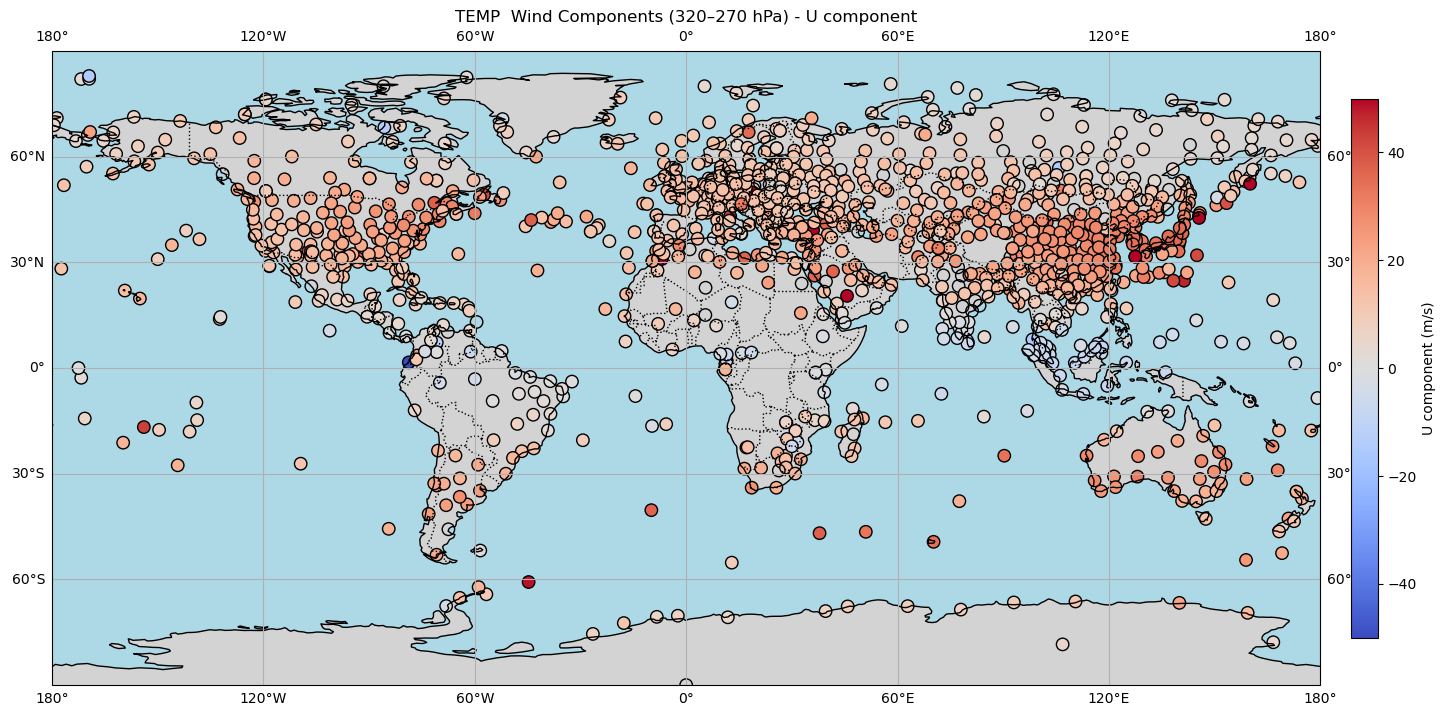

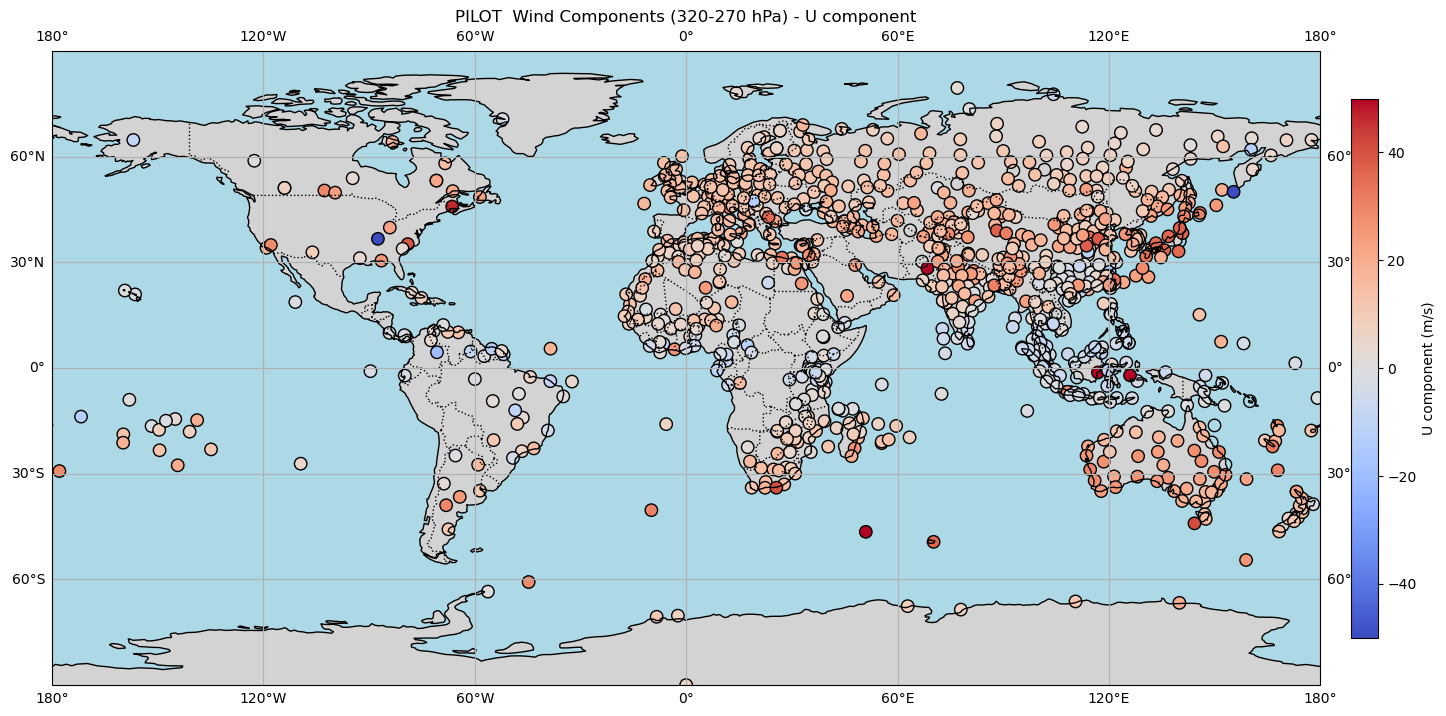

In [7]:
plot_station_winds_uv(np.array(results)[:,0,:], wind='u', title="TEMP  Wind Components (320–270 hPa)")
plot_station_winds_uv(np.array(results)[:,1,:], wind='u', title="PILOT  Wind Components (320-270 hPa)")


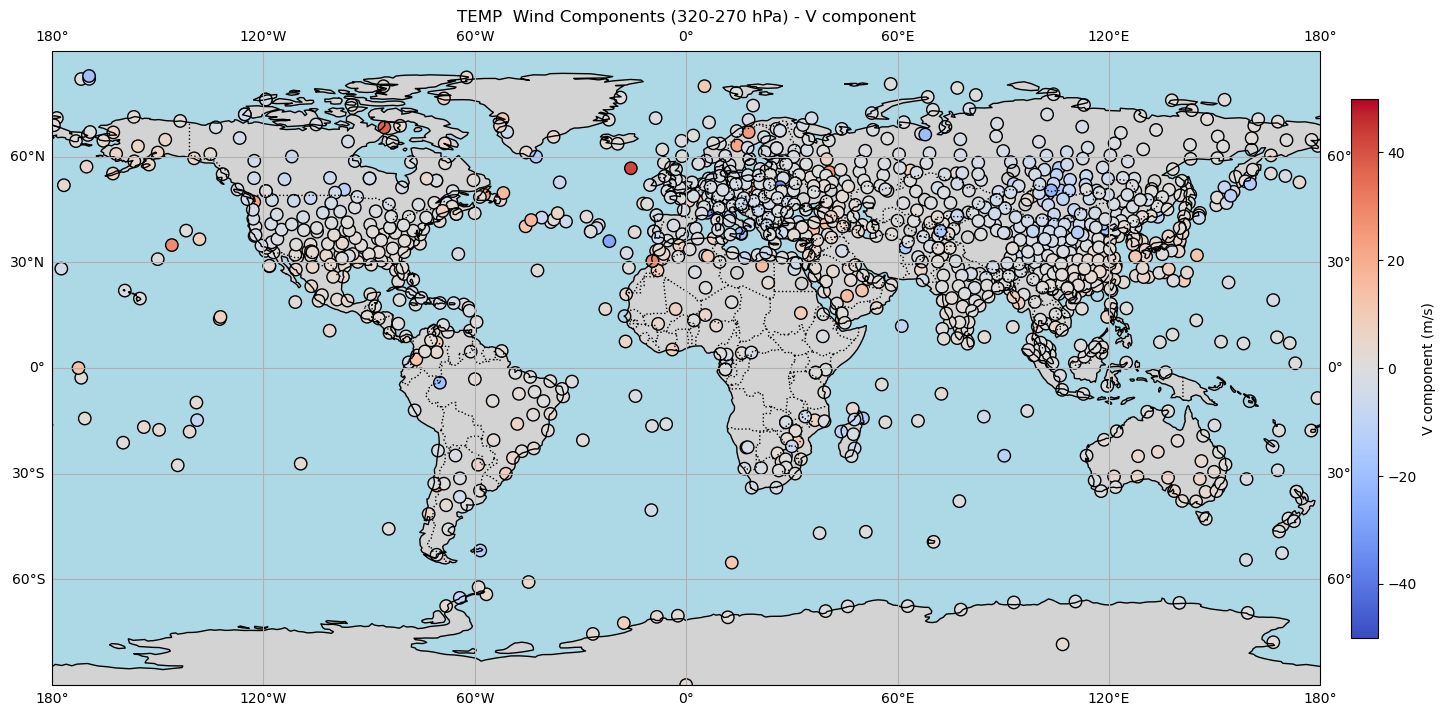

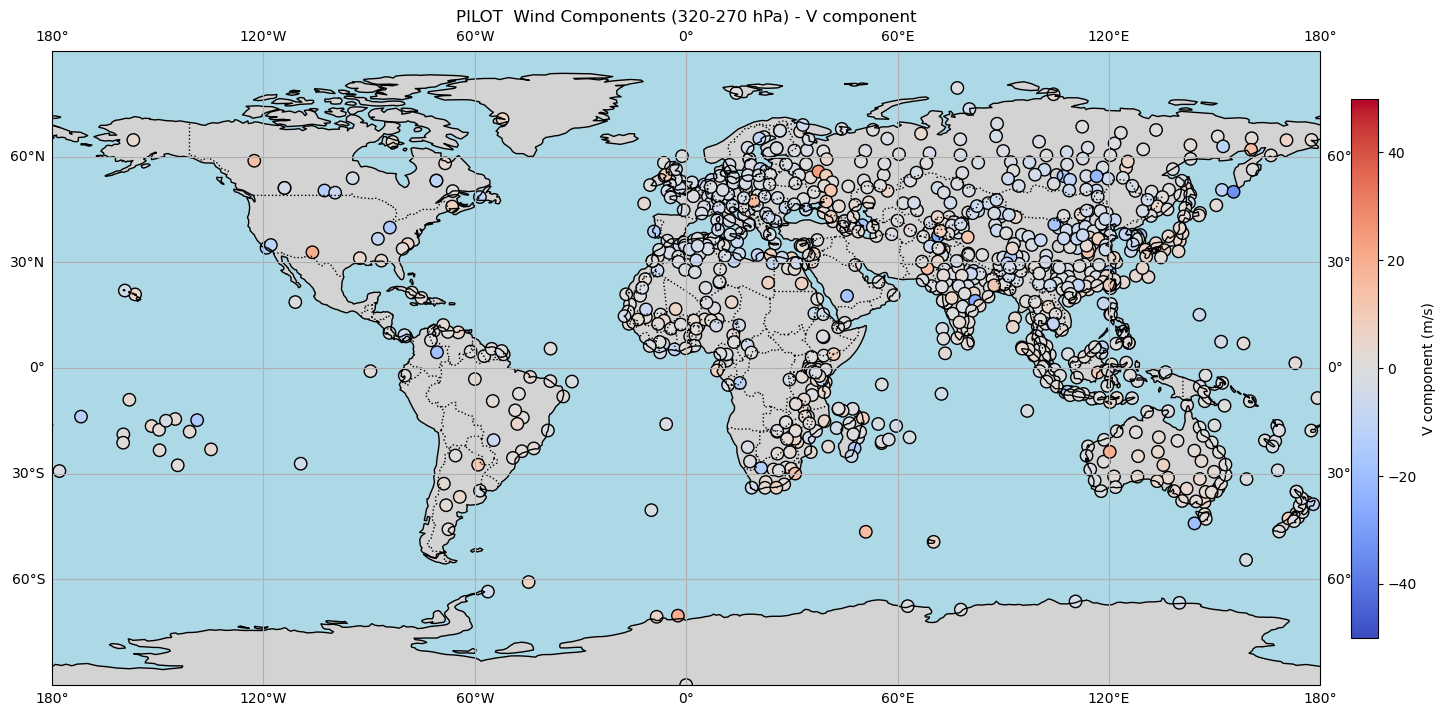

In [8]:
plot_station_winds_uv(np.array(results)[:,0,:], wind='v', title="TEMP  Wind Components (320-270 hPa)")
plot_station_winds_uv(np.array(results)[:,1,:], wind='v', title="PILOT  Wind Components (320-270 hPa)")
